# Results Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
from tqdm import tqdm

### Get accuracy data

In [2]:
# Load the results file
results_df = pd.read_csv('./exp_results/extended_ocr_accuracy_results.csv')
# print(len(results_df))
# results_df = results_df[~((results_df['Font'] == 4) & (results_df['Horizontal Angle'] == 45) & (results_df['Vertical Angle'] == 45))]
# print(len(results_df))
# Display the first few rows of the dataframe
results_df.head()

# Separate data based on font (or rather OCR engine)
font_4_data = results_df[results_df['Font'] == 4]
other_fonts_data = results_df[results_df['Font'] != 4]

### Accuracies distribution

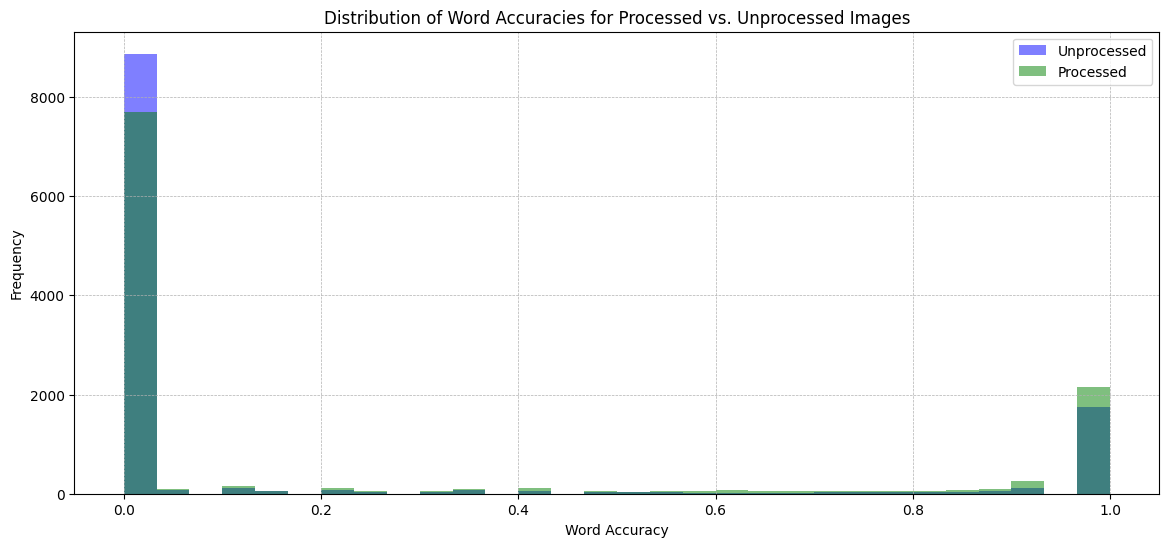

In [3]:
# Plot distribution of accuracies for processed and unprocessed images
plt.figure(figsize=(14, 6))
plt.hist(results_df['Unprocessed Accuracy'], bins=30, color="blue", alpha=0.5, label='Unprocessed')
plt.hist(results_df['Processed Accuracy'], bins=30, color="green", alpha=0.5, label='Processed')
plt.title('Distribution of Word Accuracies for Processed vs. Unprocessed Images')
plt.xlabel('Word Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

__Observation__:
1. "All or nothing": It seems that the OCR accuracy is very stable. Either the conditions ar good enough and the accuracy will be 100%, or they won't be good enough and the accuracy will be 0%. 

__Insight__:
1. This makes detecting issues before starting a measurement much easier, giving the chance to change the parameters to a more favorable setting. 

### Distance / Lens

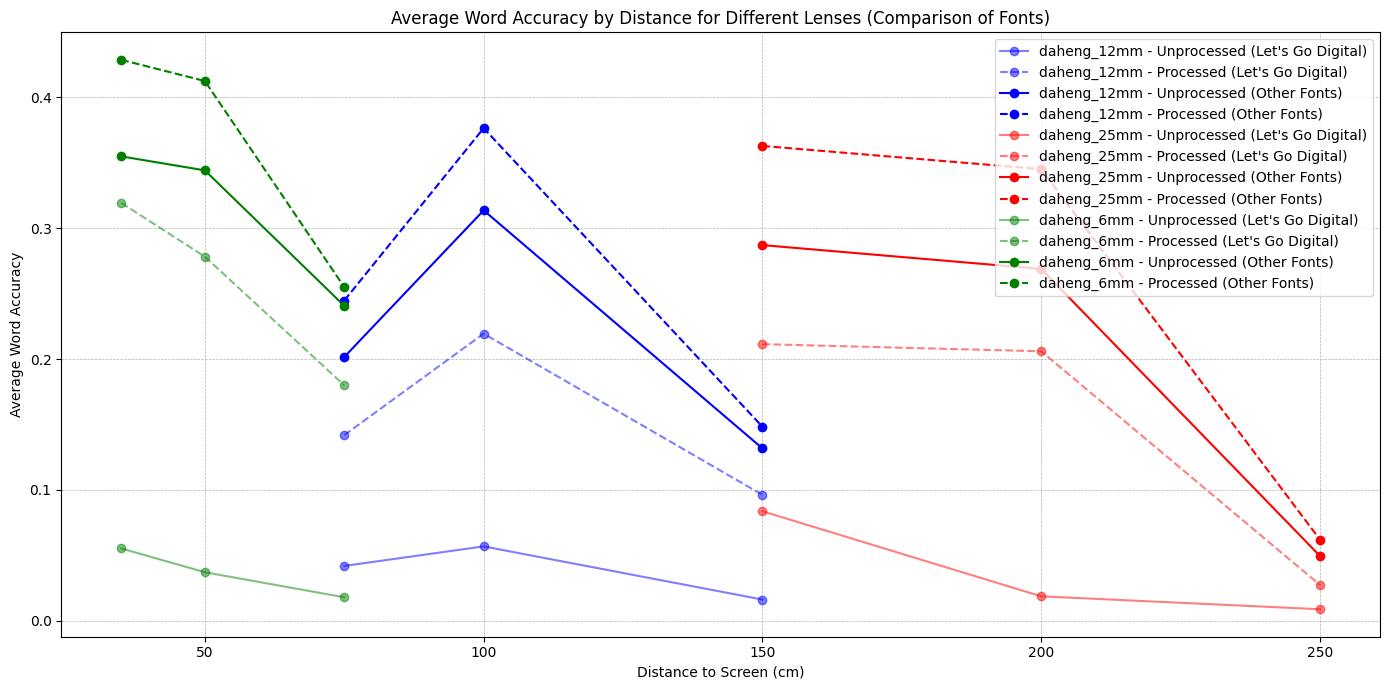

In [4]:
colors = ['blue', 'red', 'green']

# Group by Lens, Distance to Screen and calculate mean accuracy for both font categories
font_4_accuracy = font_4_data.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
other_fonts_accuracy = other_fonts_data.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
# Plot the average accuracies by distance for each lens with distinct colors for both font categories
plt.figure(figsize=(14, 7))

for idx, lens in enumerate(other_fonts_accuracy['Lens'].unique()):
    subset_font_4 = font_4_accuracy[font_4_accuracy['Lens'] == lens]
    subset_other_fonts = other_fonts_accuracy[other_fonts_accuracy['Lens'] == lens]
    
    # Let's Go Digital Font (semi-transparent)
    plt.plot(subset_font_4['Distance to Screen'], subset_font_4['Unprocessed Accuracy'], marker='o', color=colors[idx], alpha=0.5, label=f'{lens} - Unprocessed (Let\'s Go Digital)')
    plt.plot(subset_font_4['Distance to Screen'], subset_font_4['Processed Accuracy'], marker='o', linestyle='--', color=colors[idx], alpha=0.5, label=f'{lens} - Processed (Let\'s Go Digital)')
    
    # Other Fonts
    plt.plot(subset_other_fonts['Distance to Screen'], subset_other_fonts['Unprocessed Accuracy'], marker='o', color=colors[idx], label=f'{lens} - Unprocessed (Other Fonts)')
    plt.plot(subset_other_fonts['Distance to Screen'], subset_other_fonts['Processed Accuracy'], marker='o', linestyle='--', color=colors[idx], label=f'{lens} - Processed (Other Fonts)')

plt.title("Average Word Accuracy by Distance for Different Lenses (Comparison of Fonts)")
plt.ylabel('Average Word Accuracy')
plt.xlabel('Distance to Screen (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

__Observation__:
1. Accuracy seems to be marginally better for shorter focal lengths (why?)
2. Moving further away than the optimal distance for a lens degrades the accuracy rapidly
3. Moving closer than the optimal distance can sometimes marginally improve the accuracy 

__Insight__:
- Get as close as permitted by the FoV to the screen 
- (3) suggests that the number of pixels in the character is more valuable than its sharpness  

### Image processing vs. color

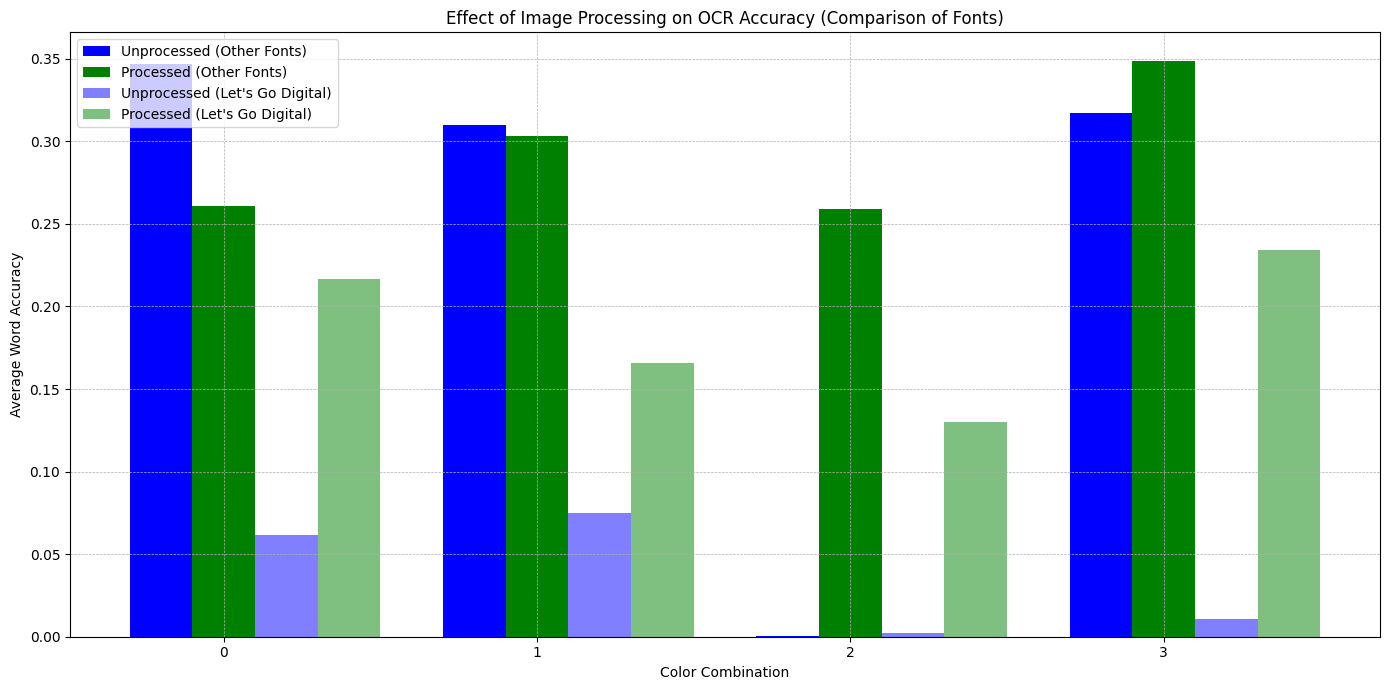

In [5]:
# Group by Color Combination to calculate mean accuracy for Font 4 and other fonts
font_4_color_accuracy_filtered = font_4_data.groupby('Color Combination')[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
other_fonts_color_accuracy_filtered = other_fonts_data.groupby('Color Combination')[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()

# Setting up bar width and x-axis locations
bar_width = 0.2
r1 = range(len(font_4_color_accuracy_filtered))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting
plt.figure(figsize=(14, 7))

# Plotting bars for each category
plt.bar(r1, other_fonts_color_accuracy_filtered['Unprocessed Accuracy'], width=bar_width, color='blue', label='Unprocessed (Other Fonts)')
plt.bar(r2, other_fonts_color_accuracy_filtered['Processed Accuracy'], width=bar_width, color='green', label='Processed (Other Fonts)')
plt.bar(r3, font_4_color_accuracy_filtered['Unprocessed Accuracy'], width=bar_width, color='blue', alpha=0.5, label='Unprocessed (Let\'s Go Digital)')
plt.bar(r4, font_4_color_accuracy_filtered['Processed Accuracy'], width=bar_width, color='green', alpha=0.5, label='Processed (Let\'s Go Digital)')

# Setting the x-axis labels
plt.xticks([r + bar_width for r in range(len(font_4_color_accuracy_filtered))], font_4_color_accuracy_filtered['Color Combination'])

# Other plot settings
plt.title('Effect of Image Processing on OCR Accuracy (Comparison of Fonts)')
plt.ylabel('Average Word Accuracy')
plt.xlabel('Color Combination')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()


__Observation__:
1. Image processing always advantageous for font 4 (PyTesseract)
2. Processing the image surprisingly deteriorates the accuracy for font 1 (black on white) for EasyOCR, and is marginally better for white black
3. Accuracy is 0% for font 2 (red on black)

__Insight__:
- Text in black and white should be left unprocessed.
- As in some cases the colors change through time, a color detection method to adapt the image processing pipeline would bring true value.

## Angles

C:\Users\diego\AppData\Local\Temp\ipykernel_13652\3953191762.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_other_fonts = other_fonts_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy')
C:\Users\diego\AppData\Local\Temp\ipykernel_13652\3953191762.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_4_font = font_4_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy')


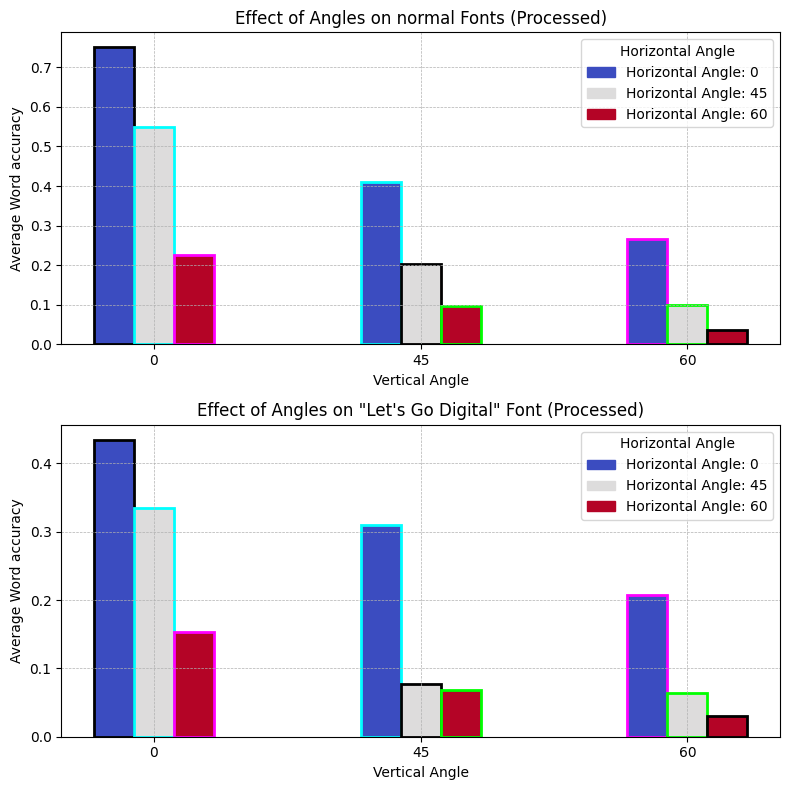

In [6]:
# Adjusting the function to get the edge color based on the angle combinations
def get_edge_color(angle_combination):
    # Convert the tuple of angles to a set
    angle_set = set(angle_combination)
    
    # Define the color mapping based on unique angle sets
    color_mapping = {
        frozenset([0, 45]): 'cyan',
        frozenset([0, 60]): 'magenta',
        frozenset([45, 60]): 'lime',
        frozenset([0]): 'black',
        frozenset([45]): 'black',
        frozenset([60]): 'black'
    }
    
    return color_mapping[frozenset(angle_set)]


# Group by Horizontal and Vertical Angle to calculate mean accuracy for Font 4 and other fonts
other_fonts_angle_accuracy = other_fonts_data.groupby(['Horizontal Angle', 'Vertical Angle'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
font_4_angle_accuracy = font_4_data.groupby(['Horizontal Angle', 'Vertical Angle'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()

df_other_fonts = other_fonts_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy')
df_4_font = font_4_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy')


# Plotting a grouped bar plot with specified edge and fill colors
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Create a colormap based on the horizontal angles
cmap = plt.get_cmap("coolwarm")
color_fill = cmap([0, 0.5, 1])

# Setting the positions and width for the bars
bar_width = 0.15
positions = np.arange(len(df_other_fonts.index))

for idx, column in enumerate(df_other_fonts.columns):
    bars = axes[0].bar(positions + idx*bar_width, df_other_fonts[column], width=bar_width, 
                  label=f'Horizontal Angle: {column}', 
                  color=color_fill[idx], 
                  edgecolor=[get_edge_color((vert_angle, column)) for vert_angle in df_other_fonts.index], 
                  linewidth=2)

# Create a custom legend without edge colors
handles, labels = axes[0].get_legend_handles_labels()
legend_bars = [plt.Rectangle((0,0),1,1, color=color_fill[idx]) for idx in range(len(handles))]
axes[0].legend(legend_bars, labels, title="Horizontal Angle")

# Set the axis labels and title
axes[0].set_xlabel('Vertical Angle')
axes[0].set_ylabel('Average Word accuracy')
axes[0].set_title('Effect of Angles on normal Fonts (Processed)')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_xticks(positions + bar_width)
axes[0].set_xticklabels(df_other_fonts.index)

for idx, column in enumerate(df_4_font.columns):
    bars = axes[1].bar(positions + idx*bar_width, df_4_font[column], width=bar_width, 
                  label=f'Horizontal Angle: {column}', 
                  color=color_fill[idx], 
                  edgecolor=[get_edge_color((vert_angle, column)) for vert_angle in df_4_font.index], 
                  linewidth=2)

# Create a custom legend without edge colors
handles, labels = axes[1].get_legend_handles_labels()
legend_bars = [plt.Rectangle((0,0),1,1, color=color_fill[idx]) for idx in range(len(handles))]
axes[1].legend(legend_bars, labels, title="Horizontal Angle")

# Set the axis labels and title
axes[1].set_xlabel('Vertical Angle')
axes[1].set_ylabel('Average Word accuracy')
axes[1].set_title('Effect of Angles on "Let\'s Go Digital" Font (Processed)')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_xticks(positions + bar_width)
axes[1].set_xticklabels(df_4_font.index)

# Display the plot
plt.tight_layout()
plt.show()

In [7]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# # Set equal spacing for ticks
# x_ticks = np.sort(other_fonts_angle_accuracy['Horizontal Angle'].unique())
# y_ticks = np.sort(other_fonts_angle_accuracy['Vertical Angle'].unique())

# # Data for contour plots
# X1, Y1 = np.meshgrid(other_fonts_angle_accuracy['Horizontal Angle'].unique(), other_fonts_angle_accuracy['Vertical Angle'].unique())
# Z1 = other_fonts_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy').values

# X2, Y2 = np.meshgrid(font_4_angle_accuracy['Horizontal Angle'].unique(), font_4_angle_accuracy['Vertical Angle'].unique())
# Z2 = font_4_angle_accuracy.pivot('Vertical Angle', 'Horizontal Angle', 'Processed Accuracy').values


# # Contour plots for Other Fonts
# c1 = axes[0].contourf(X1, Y1, Z1, cmap='RdYlGn', levels=15)
# axes[0].set_title('Effect of Angles on Normal Fonts (Processed)')
# axes[0].set_xlabel('Horizontal Angle')
# axes[0].set_ylabel('Vertical Angle')
# axes[0].set_xticks(x_ticks)
# axes[0].set_yticks(y_ticks)
# axes[0].axis('equal')  # Set axis to be equal
# fig.colorbar(c1, ax=axes[0], label='Average Word Accuracy')

# # Contour plots for Font 4
# c2 = axes[1].contourf(X2, Y2, Z2, cmap='RdYlGn', levels=15)
# axes[1].set_title('Effect of Angles on "Let\'s Go Digital" Font (Processed)')
# axes[1].set_xlabel('Horizontal Angle')
# axes[1].set_ylabel('Vertical Angle')
# axes[1].set_xticks(x_ticks)
# axes[1].set_yticks(y_ticks)
# axes[1].axis('equal')  # Set axis to be equal
# fig.colorbar(c2, ax=axes[1], label='Average Word Accuracy')

# plt.tight_layout()
# plt.show()


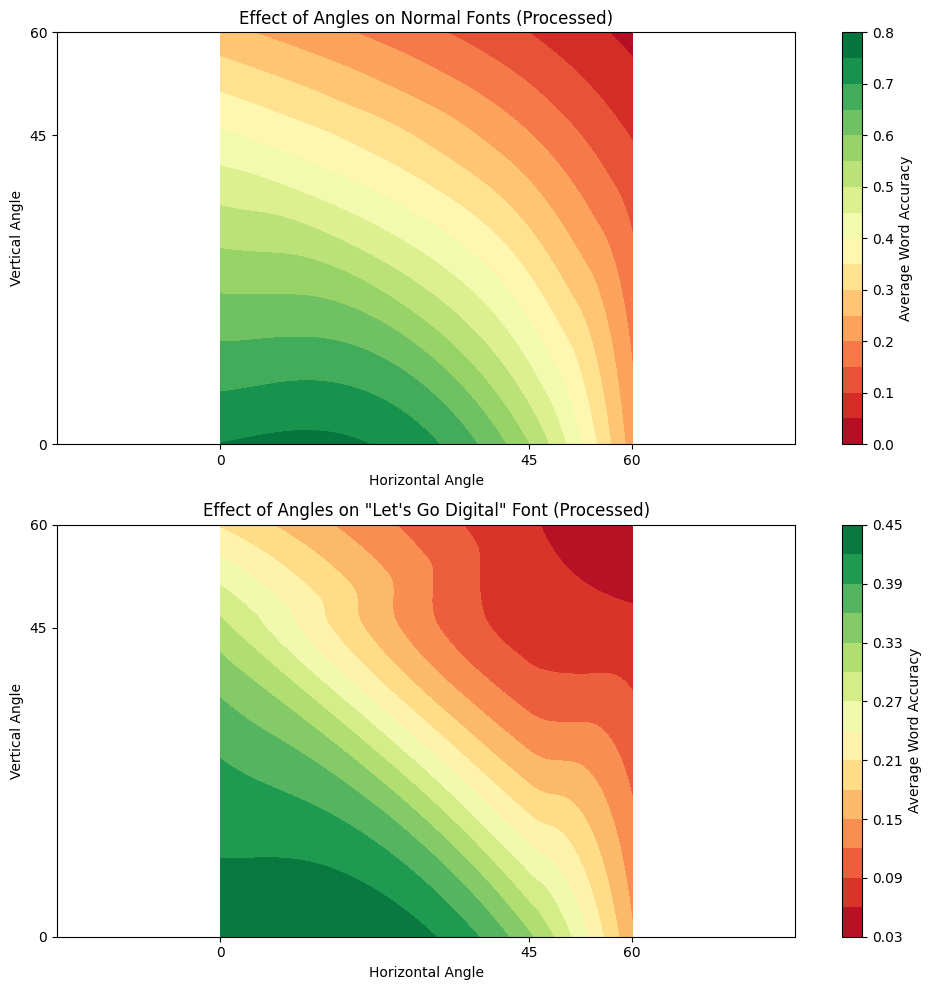

In [8]:
# Generate dense mesh grid
x = np.linspace(0, 60, 500)
y = np.linspace(0, 60, 500)
X_dense, Y_dense = np.meshgrid(x, y)

# Set equal spacing for ticks
x_ticks = np.sort(other_fonts_angle_accuracy['Horizontal Angle'].unique())
y_ticks = np.sort(other_fonts_angle_accuracy['Vertical Angle'].unique())

# Interpolate to denser grid for Other Fonts
Z1_dense = griddata((other_fonts_angle_accuracy['Horizontal Angle'].values, 
                     other_fonts_angle_accuracy['Vertical Angle'].values), 
                    other_fonts_angle_accuracy['Processed Accuracy'].values, 
                    (X_dense, Y_dense), 
                    method='cubic')

# Interpolate to denser grid for Font 4
Z2_dense = griddata((font_4_angle_accuracy['Horizontal Angle'].values, 
                     font_4_angle_accuracy['Vertical Angle'].values), 
                    font_4_angle_accuracy['Processed Accuracy'].values, 
                    (X_dense, Y_dense), 
                    method='cubic')

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Contour plots for Other Fonts
c1 = axes[0].contourf(X_dense, Y_dense, Z1_dense, cmap='RdYlGn', levels=15)
axes[0].set_title('Effect of Angles on Normal Fonts (Processed)')
axes[0].set_xlabel('Horizontal Angle')
axes[0].set_ylabel('Vertical Angle')
axes[0].set_xticks(x_ticks)
axes[0].set_yticks(y_ticks)
axes[0].axis('equal')
fig.colorbar(c1, ax=axes[0], label='Average Word Accuracy')

# Contour plots for Font 4
c2 = axes[1].contourf(X_dense, Y_dense, Z2_dense, cmap='RdYlGn', levels=15)
axes[1].set_title('Effect of Angles on "Let\'s Go Digital" Font (Processed)')
axes[1].set_xlabel('Horizontal Angle')
axes[1].set_ylabel('Vertical Angle')
axes[1].set_xticks(x_ticks)
axes[1].set_yticks(y_ticks)
axes[1].axis('equal')
fig.colorbar(c2, ax=axes[1], label='Average Word Accuracy')

plt.tight_layout()
plt.show()

## Accuracy with good parameters
- Angles at max 45°
- Text size Medium or Big
- Screen Brightness at 100%

In [9]:
favorable_data = results_df[
    # ~((results_df['Horizontal Angle'] == 45) & (results_df['Vertical Angle'] == 45)) &
    (results_df['Horizontal Angle'] <= 45) &
    (results_df['Vertical Angle'] <= 45) &
    (results_df['Size'].isin(['Big', 'Medium'])) &
    (results_df['Screen Brightness'] == 100)
]

# Separating data based on font
font_4_favorable = favorable_data[favorable_data['Font'] == 4]
other_fonts_favorable = favorable_data[favorable_data['Font'] != 4]

# Grouping by lens and distance for average accuracy
font_4_lens_distance_accuracy = font_4_favorable.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
other_fonts_lens_distance_accuracy = other_fonts_favorable.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()

print("Normal fonts")
print(other_fonts_lens_distance_accuracy)
print()
print("Let's Go Digital")
print(font_4_lens_distance_accuracy) 

Normal fonts
          Lens  Distance to Screen  Unprocessed Accuracy  Processed Accuracy
0  daheng_12mm                  75              0.546528            0.709028
1  daheng_12mm                 100              0.748264            0.966667
2  daheng_12mm                 150              0.570486            0.686111
3  daheng_25mm                 150              0.746528            0.972917
4  daheng_25mm                 200              0.746875            0.966319
5  daheng_25mm                 250              0.315625            0.406250
6   daheng_6mm                  35              0.637847            0.859028
7   daheng_6mm                  50              0.617361            0.834722
8   daheng_6mm                  75              0.630556            0.750694

Let's Go Digital
          Lens  Distance to Screen  Unprocessed Accuracy  Processed Accuracy
0  daheng_12mm                  75              0.153125            0.426042
1  daheng_12mm                 100           

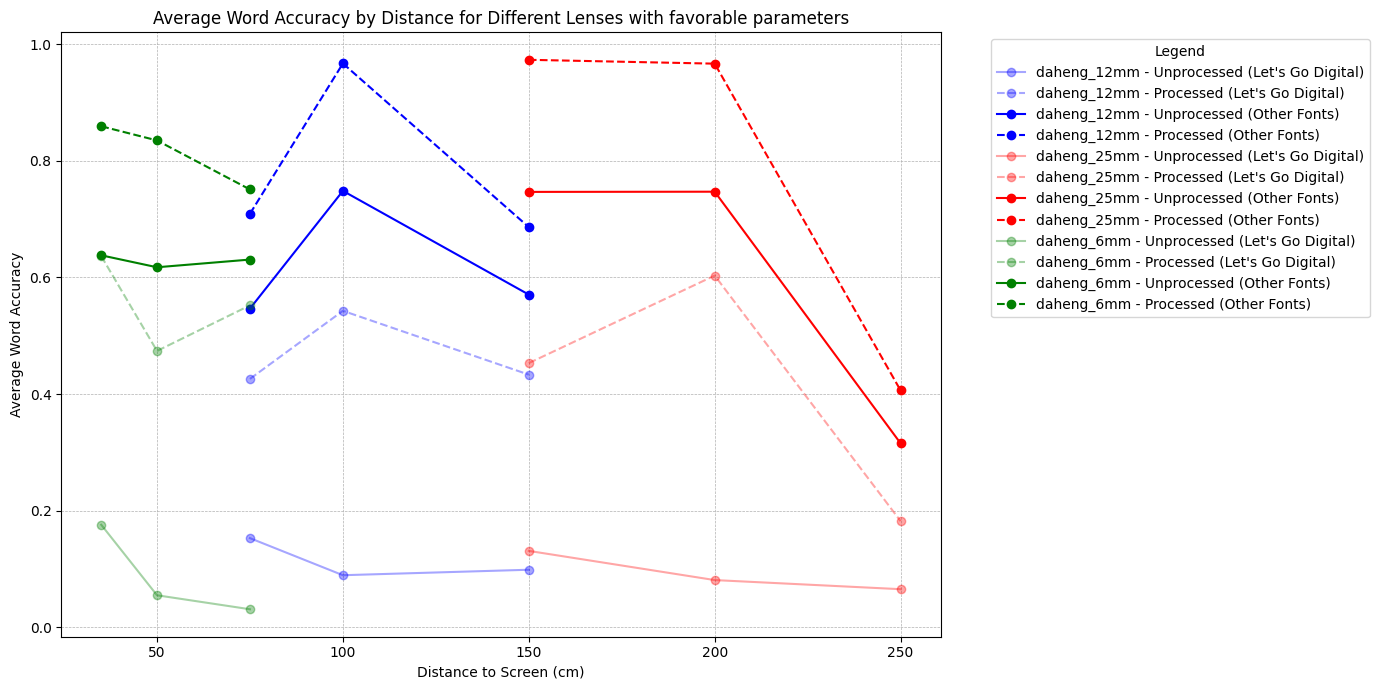

In [10]:
colors = ['blue', 'red', 'green']

# Group by Lens, Distance to Screen and calculate mean accuracy for both font categories
font_4_accuracy = font_4_favorable.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
other_fonts_accuracy = other_fonts_favorable.groupby(['Lens', 'Distance to Screen'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
# Plot the average accuracies by distance for each lens with distinct colors for both font categories
plt.figure(figsize=(14, 7))

for idx, lens in enumerate(other_fonts_accuracy['Lens'].unique()):
    subset_font_4 = font_4_accuracy[font_4_accuracy['Lens'] == lens]
    subset_other_fonts = other_fonts_accuracy[other_fonts_accuracy['Lens'] == lens]
    
    # Let's Go Digital Font (semi-transparent)
    plt.plot(subset_font_4['Distance to Screen'], subset_font_4['Unprocessed Accuracy'], marker='o', color=colors[idx], alpha=0.35, label=f'{lens} - Unprocessed (Let\'s Go Digital)')
    plt.plot(subset_font_4['Distance to Screen'], subset_font_4['Processed Accuracy'], marker='o', linestyle='--', color=colors[idx], alpha=0.35, label=f'{lens} - Processed (Let\'s Go Digital)')
    
    # Other Fonts
    plt.plot(subset_other_fonts['Distance to Screen'], subset_other_fonts['Unprocessed Accuracy'], marker='o', color=colors[idx], label=f'{lens} - Unprocessed (Other Fonts)')
    plt.plot(subset_other_fonts['Distance to Screen'], subset_other_fonts['Processed Accuracy'], marker='o', linestyle='--', color=colors[idx], label=f'{lens} - Processed (Other Fonts)')

plt.title("Average Word Accuracy by Distance for Different Lenses with favorable parameters")
plt.ylabel('Average Word Accuracy')
plt.xlabel('Distance to Screen (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', title='Legend', bbox_to_anchor=(1.05, 1), ncol=1)
plt.tight_layout()
plt.show()

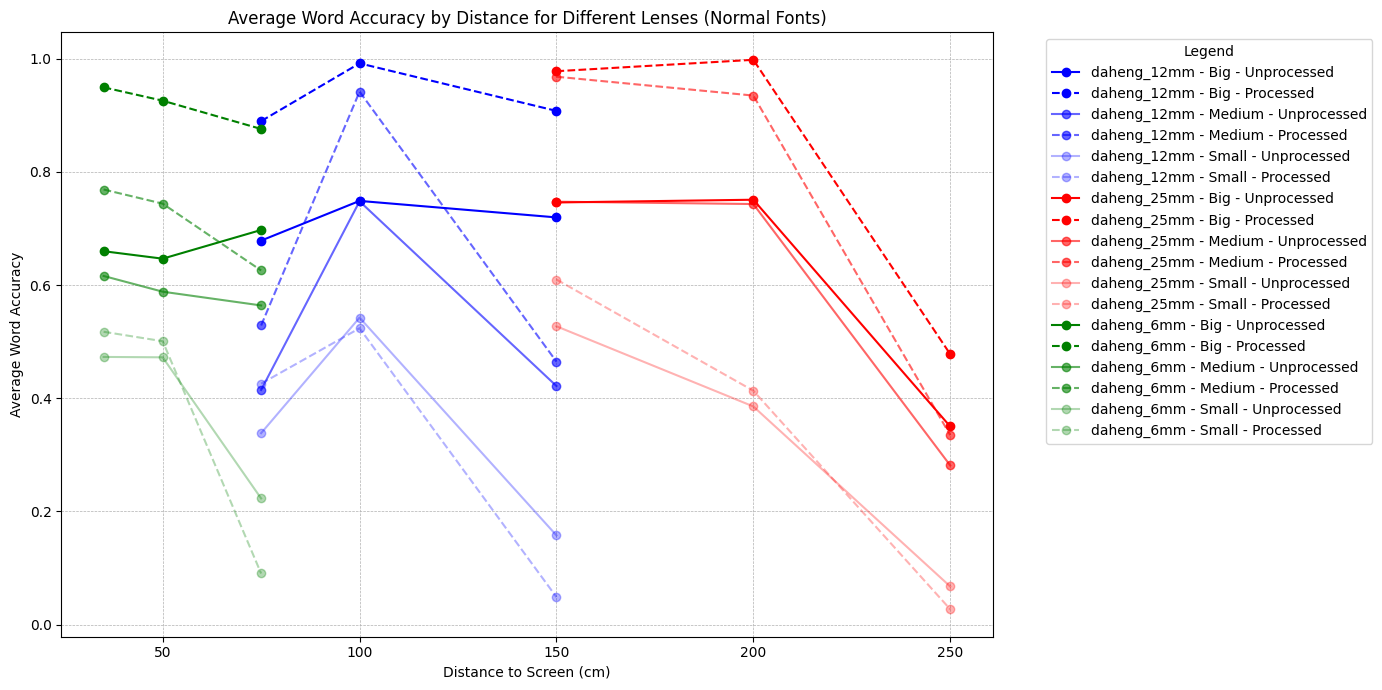

In [11]:
# Filtering the data for favorable parameters
favorable_data = results_df[
    (results_df['Horizontal Angle'] <= 45) &
    (results_df['Vertical Angle'] <= 45) &
    (results_df['Screen Brightness'] == 100)
]

other_fonts_favorable = favorable_data[favorable_data['Font'] != 4]

# Group by Lens, Distance to Screen, and Size to calculate mean accuracy for other fonts
other_fonts_accuracy_size = other_fonts_favorable.groupby(['Lens', 'Distance to Screen', 'Size'])[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()

# Plot the average accuracies by distance for each lens with distinct colors for other fonts, separated by size
plt.figure(figsize=(14, 7))

# Alpha values for different sizes
alpha_values = {'Big': 1, 'Medium': 0.6, 'Small': 0.3}

for idx, lens in enumerate(other_fonts_accuracy_size['Lens'].unique()):
    subset = other_fonts_accuracy_size[other_fonts_accuracy_size['Lens'] == lens]
    
    for size in ['Big', 'Medium', 'Small']:
        subset_size = subset[subset['Size'] == size]
        
        # Unprocessed data
        plt.plot(subset_size['Distance to Screen'], subset_size['Unprocessed Accuracy'], marker='o', color=colors[idx], alpha=alpha_values[size], label=f'{lens} - {size} - Unprocessed')
        
        # Processed data
        plt.plot(subset_size['Distance to Screen'], subset_size['Processed Accuracy'], marker='o', linestyle='--', color=colors[idx], alpha=alpha_values[size], label=f'{lens} - {size} - Processed')

plt.title("Average Word Accuracy by Distance for Different Lenses (Normal Fonts)")
plt.ylabel('Average Word Accuracy')
plt.xlabel('Distance to Screen (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', title='Legend', bbox_to_anchor=(1.05, 1), ncol=1)
plt.tight_layout()
plt.show()

## Light Conditions

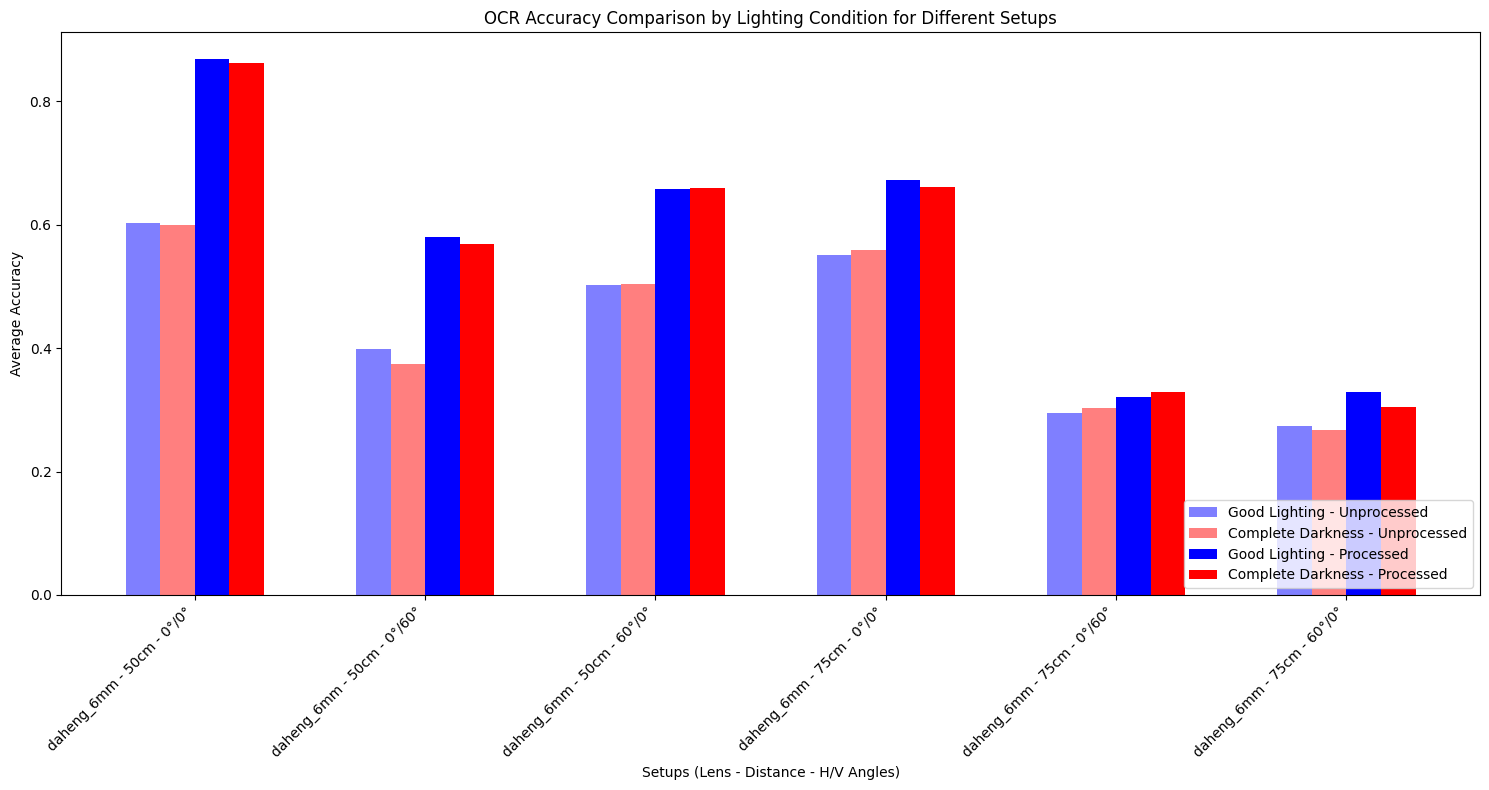

In [12]:
# Load the results file again
lighting_results_df = pd.read_csv('./exp_results/lighting_ocr_accuracy_results.csv')

# Filter data to retain only the relevant setups (Lens, Distance, Horizontal Angle, Vertical Angle)
unique_setups = lighting_results_df[['Lens', 'Distance to Screen', 'Horizontal Angle', 'Vertical Angle']].drop_duplicates().reset_index(drop=True)


# Bar width and positions
bar_width = 0.15
positions = np.arange(len(unique_setups))

# Create the plot
plt.figure(figsize=(15, 8))

# Define color mapping for lighting conditions
color_mapping = {'light': 'blue', 'dark': 'red'}
label_mapping = {
    ('light', 'Unprocessed Accuracy'): 'Good Lighting - Unprocessed',
    ('dark', 'Unprocessed Accuracy'): 'Complete Darkness - Unprocessed',
    ('light', 'Processed Accuracy'): 'Good Lighting - Processed',
    ('dark', 'Processed Accuracy'): 'Complete Darkness - Processed'
}

# Iterate over the conditions to plot bars
for i, (lighting, accuracy_type) in enumerate([('light', 'Unprocessed Accuracy'), ('dark', 'Unprocessed Accuracy'), ('light', 'Processed Accuracy'), ('dark', 'Processed Accuracy')]):
    subset = lighting_results_df[(lighting_results_df['Lighting'] == lighting)]
    accuracies = subset.groupby(['Lens', 'Distance to Screen', 'Horizontal Angle', 'Vertical Angle'])[accuracy_type].mean().values
    plt.bar(positions + i*bar_width, accuracies, width=bar_width, 
            color=color_mapping[lighting], 
            label=label_mapping[(lighting, accuracy_type)],
            alpha=0.5 if "Unprocessed" in accuracy_type else 1.0)

# Set the x-ticks labels to represent the unique setups
xtick_labels = [f"{row['Lens']} - {row['Distance to Screen']}cm - {row['Horizontal Angle']}°/{row['Vertical Angle']}°" for _, row in unique_setups.iterrows()]
plt.xticks(positions + 1.5*bar_width, xtick_labels, rotation=45, ha='right')

# Set plot details
plt.title("OCR Accuracy Comparison by Lighting Condition for Different Setups")
plt.ylabel("Average Accuracy")
plt.xlabel("Setups (Lens - Distance - H/V Angles)")
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.)
plt.tight_layout()

plt.show()

## Screen Brightness

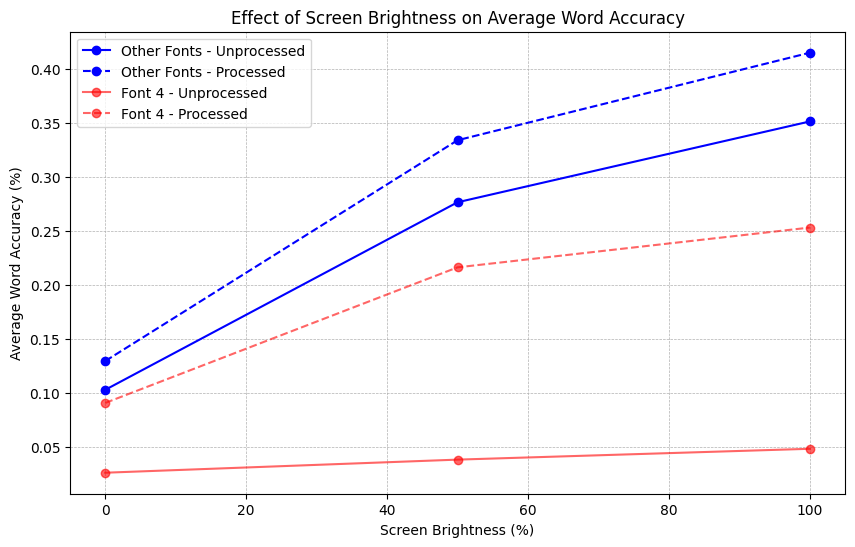

In [13]:
# Group by Screen Brightness to calculate mean accuracy for Font 4 and other fonts
font_4_brightness_accuracy = font_4_data.groupby('Screen Brightness')[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()
other_fonts_brightness_accuracy = other_fonts_data.groupby('Screen Brightness')[['Unprocessed Accuracy', 'Processed Accuracy']].mean().reset_index()

# Plotting the updated results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for other fonts
ax.plot(other_fonts_brightness_accuracy['Screen Brightness'], other_fonts_brightness_accuracy['Unprocessed Accuracy'], marker='o', label='Other Fonts - Unprocessed', color='blue')
ax.plot(other_fonts_brightness_accuracy['Screen Brightness'], other_fonts_brightness_accuracy['Processed Accuracy'], marker='o', linestyle='--', label='Other Fonts - Processed', color='blue')

# Plot data for Font 4
ax.plot(font_4_brightness_accuracy['Screen Brightness'], font_4_brightness_accuracy['Unprocessed Accuracy'], marker='o', label='Font 4 - Unprocessed', color='red', alpha=0.6)
ax.plot(font_4_brightness_accuracy['Screen Brightness'], font_4_brightness_accuracy['Processed Accuracy'], marker='o', linestyle='--', label='Font 4 - Processed', color='red', alpha=0.6)

ax.set_title('Effect of Screen Brightness on Average Word Accuracy')
ax.set_xlabel('Screen Brightness (%)')
ax.set_ylabel('Average Word Accuracy (%)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.show()

## Finding outliers

Here I am trying to find cases where the accuracy was unexpectedly low, by comparing it to similar cases with objectively more favorable parameters as follows:
- Horizontal and vertical angles: 0° > 45° > 60°
- Distance: under = equal to > above optimal distance
- Size: Big > Medium > Small
- Screen brightness: 100% > 50% > 0%
<br>

The goal here is to try to identify unknown patterns.

In [14]:
# # Define a function to determine if a row's parameters are more favorable than those of another row
# def is_strictly_better(row1, row2):
#     """
#     Determines if the parameters of row1 are strictly better than those of row2.
#     """
#     lens_optimal_distances = {
#         "daheng_6mm": 50,
#         "daheng_12mm": 100,
#         "daheng_25mm": 200
#     }
    
#     # Check angle conditions
#     if row1["Horizontal Angle"] >= row2["Horizontal Angle"] or row1["Vertical Angle"] >= row2["Vertical Angle"]:
#         return False
    
#     # Check distance and lens conditions
#     if row1["Lens"] == row2["Lens"] and row1["Distance to Screen"] > min(row2["Distance to Screen"], lens_optimal_distances[row1["Lens"]]):
#         return False
    
#     # Check brightness condition
#     if row1["Screen Brightness"] <= row2["Screen Brightness"]:
#         return False

#     # Check size condition
#     size_order = ["Small", "Medium", "Big"]
#     if size_order.index(row1["Size"]) <= size_order.index(row2["Size"]):
#         return False

#     return True

# # List to store the identified outliers
# outliers = []

# # Iterate over unique values of the parameters by which we want to filter
# for font in tqdm(results_df['Font'].unique()):
#     for color_combination in results_df['Color Combination'].unique():
#         for lens in results_df['Lens'].unique():
#             for exposure_time in results_df['Exposure Time'].unique():
#                 # Filter data by these parameters
#                 subset = results_df[(results_df['Font'] == font) & 
#                                     (results_df['Color Combination'] == color_combination) & 
#                                     (results_df['Lens'] == lens) & 
#                                     (results_df['Exposure Time'] == exposure_time)]
                
#                 # Within this subset, look for cases where one case has better parameters but worse accuracy than another case
#                 for idx1, row1 in subset.iterrows():
#                     for idx2, row2 in subset.iterrows():
#                         if idx1 != idx2 and is_strictly_better(row1, row2) and row1["Processed Accuracy"] < row2["Processed Accuracy"]:
#                             # outliers.append({
#                             #     "Outlier Font": row1["Font"],
#                             #     "Outlier Color Combination": row1["Color Combination"],
#                             #     "Outlier Size": row1["Size"],
#                             #     "Outlier Accuracy": row1["Processed Accuracy"],
#                             #     "Comparison Font": row2["Font"],
#                             #     "Comparison Color Combination": row2["Color Combination"],
#                             #     "Comparison Size": row2["Size"],
#                             #     "Comparison Accuracy": row2["Processed Accuracy"],
#                             #     "Outlier Horizontal Angle": row1["Horizontal Angle"],
#                             #     "Outlier Vertical Angle": row1["Vertical Angle"],
#                             #     "Comparison Horizontal Angle": row2["Horizontal Angle"],
#                             #     "Comparison Vertical Angle": row2["Vertical Angle"],
#                             # })
#                             outliers.append({
#                                 "Outlier": f"{row1['Font']},{row1['Color Combination']},{row1['Lens']},{row1['Distance to Screen']},{row1['Screen Brightness']},{row1['Horizontal Angle']},{row1['Vertical Angle']},{row1['Exposure Time']},{row1['Size']},{row1['Unprocessed Accuracy']},{row1['Processed Accuracy']}",
#                                 "Compared": f"{row2['Font']},{row2['Color Combination']},{row2['Lens']},{row2['Distance to Screen']},{row2['Screen Brightness']},{row2['Horizontal Angle']},{row2['Vertical Angle']},{row2['Exposure Time']},{row2['Size']},{row2['Unprocessed Accuracy']},{row2['Processed Accuracy']}"
#                             })

# # Convert the outlier data to a DataFrame
# outliers_df = pd.DataFrame(outliers)
# outliers_df.to_csv('exp_results/outliers.csv', index=False)
# outliers_df

# Exposure vs Gain

In [15]:
exp_gain_results = pd.read_csv('./exp_results/exp_gain_results.csv')
exp_gain_bad_params_df = exp_gain_results[(exp_gain_results['Screen Brightness'] != 100)]
exp_gain_good_params_df = exp_gain_results[(exp_gain_results['Screen Brightness'] == 100)]
# print(exp_gain_bad_params_df.head())
# print(exp_gain_good_params_df.head())

C:\Users\diego\AppData\Local\Temp\ipykernel_13652\3156832237.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  Z1 = exp_gain_bad_params_df.pivot('Gain', 'Exposure Time', 'Processed Accuracy').values


ValueError: Index contains duplicate entries, cannot reshape

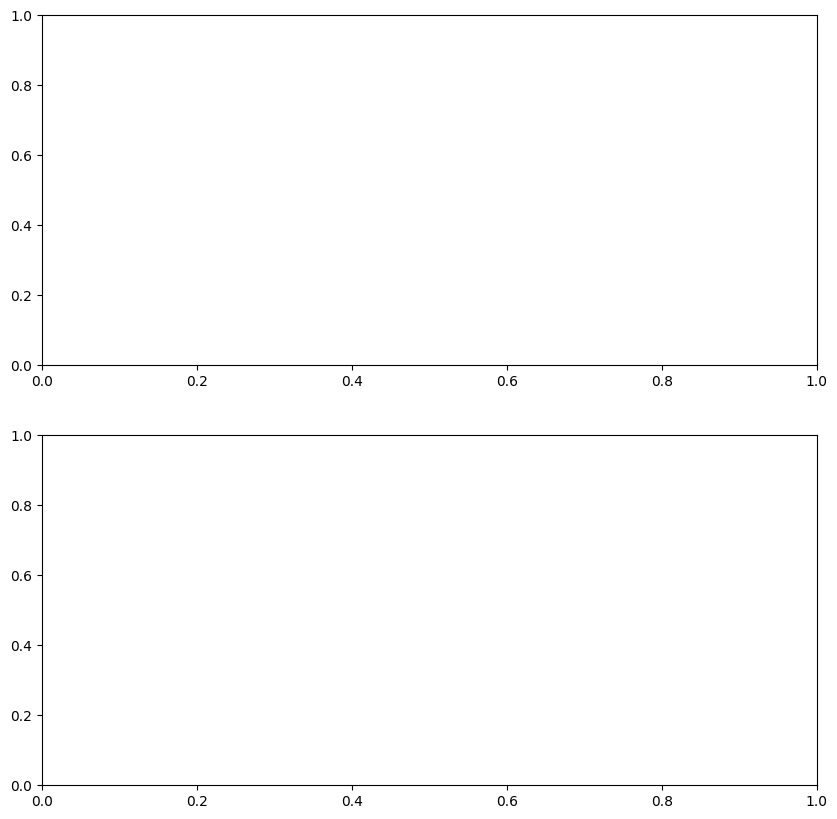

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# # Set equal spacing for ticks
# x_ticks = np.sort(other_fonts_angle_accuracy['Horizontal Angle'].unique())
# y_ticks = np.sort(other_fonts_angle_accuracy['Vertical Angle'].unique())

# Data for contour plots
X1, Y1 = np.meshgrid(exp_gain_bad_params_df['Exposure Time'].unique(), exp_gain_bad_params_df['Gain'].unique())
Z1 = exp_gain_bad_params_df.pivot('Gain', 'Exposure Time', 'Processed Accuracy').values

X2, Y2 = np.meshgrid(exp_gain_good_params_df['Exposure Time'].unique(), exp_gain_good_params_df['Gain'].unique())
Z2 = exp_gain_good_params_df.pivot('Gain', 'Exposure Time', 'Processed Accuracy').values


# Contour plots for Other Fonts
c1 = axes[0].contourf(X1, Y1, Z1, cmap='RdYlGn', levels=15)
axes[0].set_title('Effect of different Exposure Time / Analog Gain Combinations on a Setup w/ Bad Parameters (Processed)')
axes[0].set_xlabel('Exposure Time')
axes[0].set_ylabel('Gain')
# axes[0].set_xticks(x_ticks)
# axes[0].set_yticks(y_ticks)
axes[0].axis('equal')  # Set axis to be equal
fig.colorbar(c1, ax=axes[0], label='Average Word Accuracy')

# Contour plots for Font 4
c2 = axes[1].contourf(X2, Y2, Z2, cmap='RdYlGn', levels=15)
axes[1].set_title('Effect of different Exposure Time / Analog Gain Combinations on a Setup w/ Bad Parameters (Processed)')
axes[1].set_xlabel('Exposure Time')
axes[1].set_ylabel('Gain')
# axes[1].set_xticks(x_ticks)
# axes[1].set_yticks(y_ticks)
axes[1].axis('equal')  # Set axis to be equal
fig.colorbar(c2, ax=axes[1], label='Average Word Accuracy')

plt.tight_layout()
plt.show()

c:\Users\diego\OneDrive\Bureau\BachelorArbeit\CVT-OCR-code\venv\lib\site-packages\matplotlib\contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\diego\OneDrive\Bureau\BachelorArbeit\CVT-OCR-code\venv\lib\site-packages\matplotlib\contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


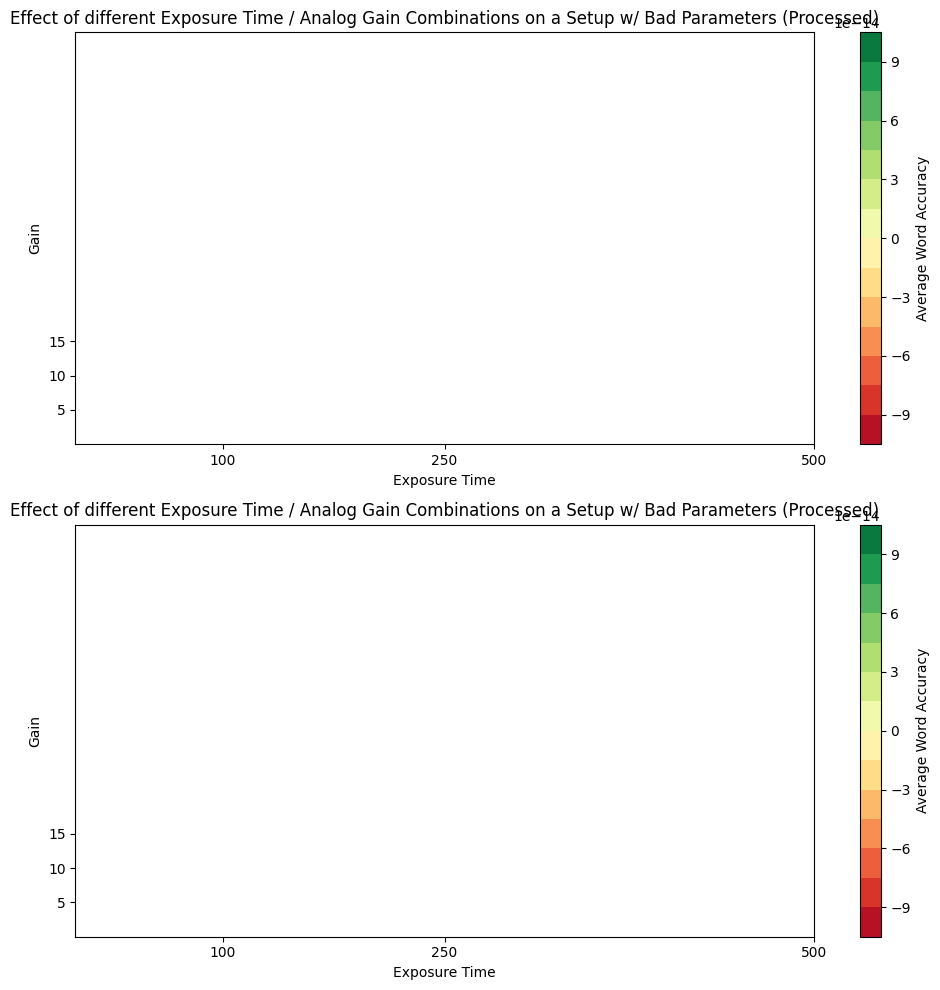

In [ ]:
# Generate dense mesh grid
x = np.linspace(0, 60, 500)
y = np.linspace(0, 60, 500)
X_dense, Y_dense = np.meshgrid(x, y)

# Set ticks
x_ticks = [100, 250, 500]
y_ticks = [5, 10, 15]

# Interpolate to denser grid c
Z1_dense = griddata((exp_gain_bad_params_df['Exposure Time'].values, 
                     exp_gain_bad_params_df['Gain'].values), 
                    exp_gain_bad_params_df['Processed Accuracy'].values, 
                    (X_dense, Y_dense), 
                    method='cubic')

# Interpolate to denser grid c
Z2_dense = griddata((exp_gain_good_params_df['Exposure Time'].values, 
                     exp_gain_good_params_df['Gain'].values), 
                    exp_gain_good_params_df['Processed Accuracy'].values, 
                    (X_dense, Y_dense), 
                    method='cubic')

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Contour plots 'Exposure Time'
c1 = axes[0].contourf(X_dense, Y_dense, Z1_dense, cmap='RdYlGn', levels=15)
axes[0].set_title('Effect of different Exposure Time / Analog Gain Combinations on a Setup w/ Bad Parameters (Processed)')
axes[0].set_xlabel('Exposure Time')
axes[0].set_ylabel('Gain')
axes[0].set_xticks(x_ticks)
axes[0].set_yticks(y_ticks)
# axes[0].axis('equal')
fig.colorbar(c1, ax=axes[0], label='Average Word Accuracy')

# Contour plots 'Gain'
c2 = axes[1].contourf(X_dense, Y_dense, Z2_dense, cmap='RdYlGn', levels=15)
axes[1].set_title('Effect of different Exposure Time / Analog Gain Combinations on a Setup w/ Bad Parameters (Processed)')
axes[1].set_xlabel('Exposure Time')
axes[1].set_ylabel('Gain')
axes[1].set_xticks(x_ticks)
axes[1].set_yticks(y_ticks)
# axes[1].axis('equal')
fig.colorbar(c2, ax=axes[1], label='Average Word Accuracy')

plt.tight_layout()
plt.show()


# Detection method performance

In [43]:
# Load the CSV data into a pandas DataFrame
df_loaded = pd.read_csv("average_detection_times.csv")

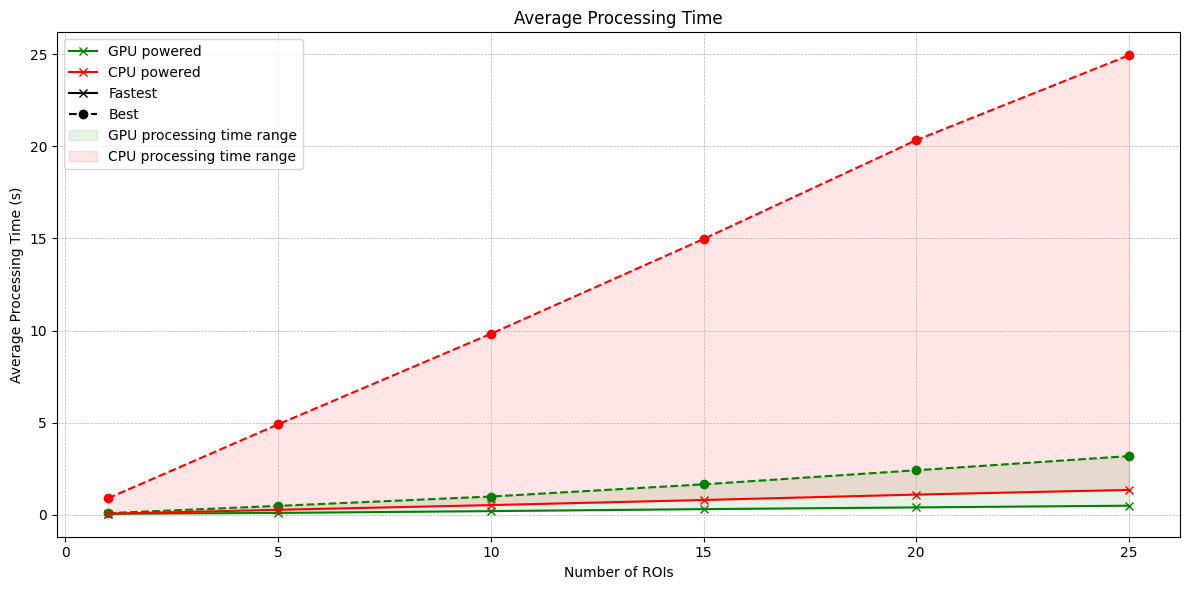

In [46]:
plt.figure(figsize=(12, 6))

# Updated names for legend
legend_names = {
    True: 'GPU powered',
    False: 'CPU powered'
}
range_names = {
    True: 'GPU processing time range',
    False: 'CPU processing time range'
}
styles = {
    "Fastest": "-",
    "Best": "--"
}
markers = {
    "Fastest": "x",
    "Best": "o"
}

# Plot the lines
for cuda in [True, False]:
    for method in ["Fastest", "Best"]:
        subset = df_loaded[(df_loaded["Cuda"] == cuda) & (df_loaded["Method"] == method)]
        label = legend_names[cuda] if method == "Fastest" else None  # Only label once per color
        plt.plot(subset["ROI #"], subset["Average Time (s)"], label=label, 
                 linestyle=styles[method], color=colors[cuda], marker=markers[method])

# Custom legend entries for the methods
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', marker='x', linestyle=styles["Fastest"], label='Fastest'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles["Best"], label='Best')]

# Create a shaded area between lines for each Cuda value
for cuda in [True, False]:
    subset_fastest = df_loaded[(df_loaded["Cuda"] == cuda) & (df_loaded["Method"] == "Fastest")]
    subset_best = df_loaded[(df_loaded["Cuda"] == cuda) & (df_loaded["Method"] == "Best")]
    plt.fill_between(subset_fastest["ROI #"], subset_fastest["Average Time (s)"], subset_best["Average Time (s)"], 
                     color=colors[cuda], alpha=0.1, label=range_names[cuda])

# Combining both legends
plt.legend(handles=[*plt.gca().get_legend_handles_labels()[0][:2], *legend_elements, *plt.gca().get_legend_handles_labels()[0][2:]], 
           labels=[*plt.gca().get_legend_handles_labels()[1][:2], *["Fastest", "Best"], *plt.gca().get_legend_handles_labels()[1][2:]])

plt.title('Average Processing Time')
plt.xlabel('Number of ROIs')
plt.ylabel('Average Processing Time (s)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
